In [1]:
import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
import shap
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import OutlierTrimmer
from catboost import CatBoostRegressor, Pool

SEED = 23

pd.set_option('display.max_columns', None)

In [2]:
#pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git

In [3]:
from amarinml import *

In [4]:
df = pd.read_csv('D:/OneDrive/datasets/sp500_diff.csv', low_memory=False)
print(df.shape)

(27723, 402)


In [5]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace = True)

In [6]:
df = df.sort_values(by=['Ticker','Date'])

In [7]:
target = 'Future_Price_pct_diff_1'
df[target]=df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(1)

In [8]:
features = df.drop(columns=[target], axis=1).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features =  df.select_dtypes(include=['int64', 'float64']).columns.tolist()                                                                                 

In [9]:
len(num_features), len(cat_features), len(features)

(398, 4, 401)

In [10]:
df.dropna(inplace = True)

In [11]:
df = df.replace([np.inf, -np.inf], 0)

In [12]:
df = df.sort_values(by=['Date','Ticker'])

In [14]:
split_date = '2024-01-01'
train_df, test_df = df.loc[df['Date'] < split_date], df.loc[df['Date'] >= split_date]

In [15]:
train_df_cut = train_df.copy()
trimmer = OutlierHandler(WinsorizerHandler(lower_quantile=0.01, upper_quantile=0.99))
train_df_cut[num_features] = trimmer.fit_transform(train_df[num_features])

In [16]:
bounds = trimmer.get_bounds()['X']
bounds

,Lower Bound,Upper Bound
Basic EPS,-2.533400,8.370000
Basic Shares Outstanding,30.000000,10189.340000
Cash Flow From Financial Activities,-10279.870000,10223.550000
Cash Flow From Investing Activities,-13045.000000,4106.440000
Cash Flow From Operating Activities,-1582.170000,12449.860000
...,...,...
Total Non-Operating Income/Expense_pct_diff_1,-12.281751,14.085268
Total Non-Operating Income/Expense_pct_diff_4,-16.566912,17.758452
eps-earnings-per-share-diluted_pct_diff_1,-8.770706,9.436241
eps-earnings-per-share-diluted_pct_diff_4,-10.000000,10.257011


In [17]:
X_train = train_df_cut[features]
y_train = train_df_cut[target]
X_test = test_df[features]
y_test = test_df[target]

In [22]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=50,
    thread_count=-1,  # Use all available threads
    task_type="CPU"   # Ensure CPU is used
)

In [23]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

0:	learn: 0.1308554	test: 0.1446737	best: 0.1446737 (0)	total: 132ms	remaining: 2m 12s
50:	learn: 0.0618796	test: 0.0911541	best: 0.0911541 (50)	total: 5.34s	remaining: 1m 39s
100:	learn: 0.0552097	test: 0.0880357	best: 0.0879555 (97)	total: 10.6s	remaining: 1m 34s
150:	learn: 0.0503406	test: 0.0866251	best: 0.0866251 (150)	total: 15.9s	remaining: 1m 29s
200:	learn: 0.0465321	test: 0.0862031	best: 0.0860611 (199)	total: 21.1s	remaining: 1m 24s
250:	learn: 0.0436274	test: 0.0858490	best: 0.0857907 (240)	total: 26.6s	remaining: 1m 19s
300:	learn: 0.0409821	test: 0.0855416	best: 0.0855298 (299)	total: 32s	remaining: 1m 14s
350:	learn: 0.0386967	test: 0.0853507	best: 0.0853507 (350)	total: 37.3s	remaining: 1m 8s
400:	learn: 0.0366840	test: 0.0853335	best: 0.0852083 (386)	total: 42.5s	remaining: 1m 3s
450:	learn: 0.0348331	test: 0.0852570	best: 0.0852083 (386)	total: 47.7s	remaining: 58s
500:	learn: 0.0330876	test: 0.0850835	best: 0.0850478 (484)	total: 52.9s	remaining: 52.7s
550:	learn: 0.

In [24]:
# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                           feature  importance
265            MinPrice_pct_diff_1   18.979269
251            MaxPrice_pct_diff_1   14.665486
165          ClosePrice_pct_diff_1   11.911959
1                             Date   10.381222
249           MarketCap_pct_diff_1    3.590685
266            MinPrice_pct_diff_4    2.532950
70                          RSI_14    1.852447
166          ClosePrice_pct_diff_4    1.765336
252            MaxPrice_pct_diff_4    1.629171
367            StdPrice_pct_diff_1    1.378916
35                     MACD_Signal    1.327073
347              RSI_14_pct_diff_1    1.246943
257           MeanPrice_pct_diff_1    0.925037
331         PriceToBook_pct_diff_1    0.915151
134                    GICS Sector    0.831769
250           MarketCap_pct_diff_4    0.763187
263        MedianVolume_pct_diff_1    0.715844
259          MeanVolume_pct_diff_1    0.689717
34                       MACD_Hist    0.688408
243                MACD_pct_diff_1    0.564208
258          

In [25]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


n_iter = 100

# Define search space
param_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'depth': Integer(3, 10),
    'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'border_count': Integer(32, 255),
    'iterations': Integer(100, 1000),
    'subsample': Real(0.5, 1.0)
}

# Define time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

# Set up Bayesian Search CV
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=tscv,
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=-1,
    n_points=4,
    random_state=SEED
)

# Fit gs
opt.fit(X_train, y_train, cat_features=cat_features, callback=callback)

# Close the progress bar
callback.pbar.close()

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.1342699	total: 55.7ms	remaining: 55.6s
50:	learn: 0.0709783	total: 2.32s	remaining: 43.2s
100:	learn: 0.0638475	total: 4.55s	remaining: 40.5s
150:	learn: 0.0604842	total: 6.74s	remaining: 37.9s
200:	learn: 0.0578100	total: 8.89s	remaining: 35.3s
250:	learn: 0.0556371	total: 11.1s	remaining: 33s
300:	learn: 0.0540653	total: 13.2s	remaining: 30.6s
350:	learn: 0.0526897	total: 15.4s	remaining: 28.4s
400:	learn: 0.0515138	total: 17.5s	remaining: 26.1s
450:	learn: 0.0504134	total: 19.6s	remaining: 23.9s
500:	learn: 0.0494412	total: 21.8s	remaining: 21.7s
550:	learn: 0.0485372	total: 24s	remaining: 19.5s
600:	learn: 0.0476882	total: 26.1s	remaining: 17.3s
650:	learn: 0.0469145	total: 28.2s	remaining: 15.1s
700:	learn: 0.0461817	total: 30.3s	remaining: 12.9s
750:	learn: 0.0454251	total: 32.5s	remaining: 10.8s
800:	learn: 0.0447644	total: 34.6s	remaining: 8.6s
850:	learn: 0.0440972	total: 36.8s	remaining: 6.44s
900:	learn: 0.0434569	total: 38.9s	remaining: 4.27s
950:	learn: 0.04286

 96%|█████████▌| 96/100 [3:42:03<09:15, 138.79s/it]

999:	learn: 0.0423043	total: 43.1s	remaining: 0us
Best score: -0.06829253433318846
Best params: OrderedDict([('bagging_temperature', 1.0), ('border_count', 173), ('depth', 5), ('iterations', 1000), ('l2_leaf_reg', 1e-09), ('learning_rate', 0.0639001651553097), ('subsample', 1.0)])


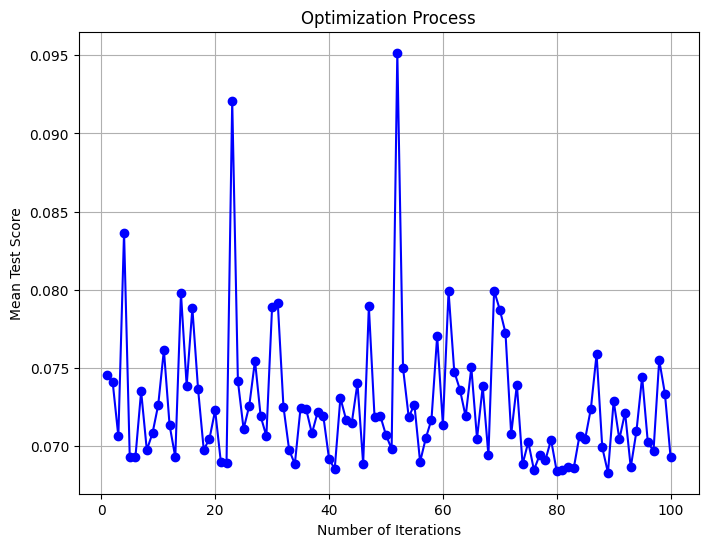

In [26]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

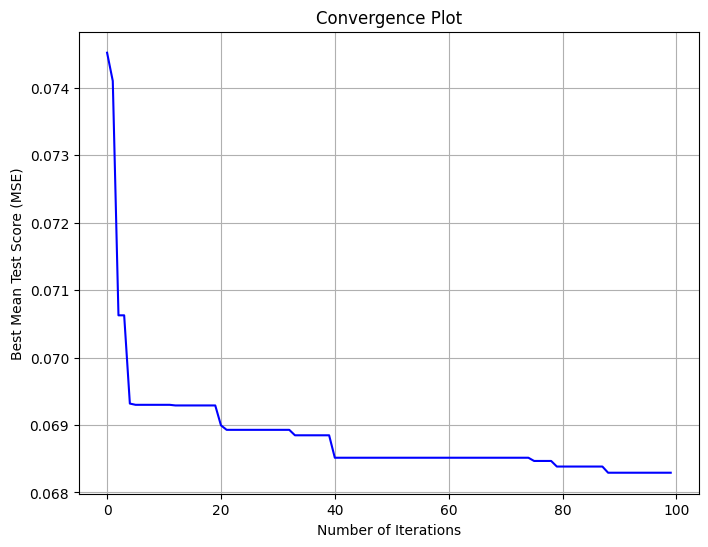

In [27]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

0:	learn: 0.0041970	total: 2.08ms	remaining: 2.07s
50:	learn: 0.0007198	total: 58.6ms	remaining: 1.09s
100:	learn: 0.0002076	total: 105ms	remaining: 935ms
150:	learn: 0.0000833	total: 149ms	remaining: 840ms
200:	learn: 0.0000376	total: 193ms	remaining: 769ms
250:	learn: 0.0000183	total: 239ms	remaining: 712ms
300:	learn: 0.0000086	total: 284ms	remaining: 660ms
350:	learn: 0.0000041	total: 325ms	remaining: 601ms
400:	learn: 0.0000021	total: 367ms	remaining: 548ms
450:	learn: 0.0000010	total: 407ms	remaining: 496ms
500:	learn: 0.0000005	total: 448ms	remaining: 446ms
550:	learn: 0.0000003	total: 489ms	remaining: 399ms
600:	learn: 0.0000001	total: 530ms	remaining: 352ms
650:	learn: 0.0000001	total: 571ms	remaining: 306ms
700:	learn: 0.0000000	total: 612ms	remaining: 261ms
750:	learn: 0.0000000	total: 656ms	remaining: 217ms
800:	learn: 0.0000000	total: 700ms	remaining: 174ms
850:	learn: 0.0000000	total: 741ms	remaining: 130ms
900:	learn: 0.0000000	total: 782ms	remaining: 85.9ms
950:	learn: 

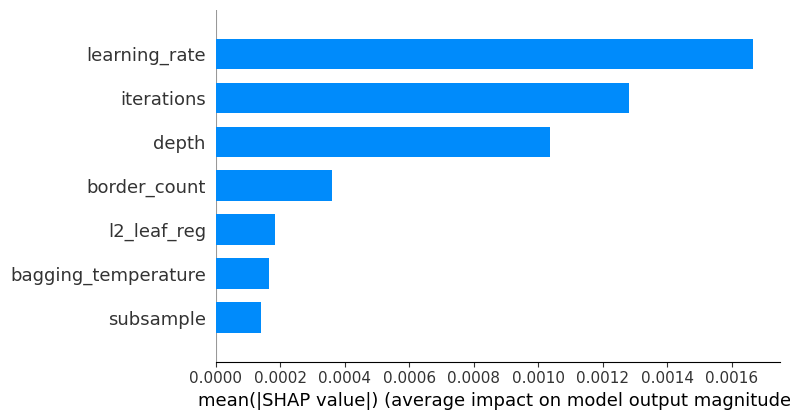

In [28]:
results = opt.cv_results_
params = results['params']
mean_test_scores = -results['mean_test_score']  # Mean test scores are negative due to the scoring used

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = copy.deepcopy(opt.best_estimator_)
hyperparam_model.fit(hyperparams_df.drop('mean_test_score', axis=1), hyperparams_df['mean_test_score'])

# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop('mean_test_score', axis=1), plot_type="bar")

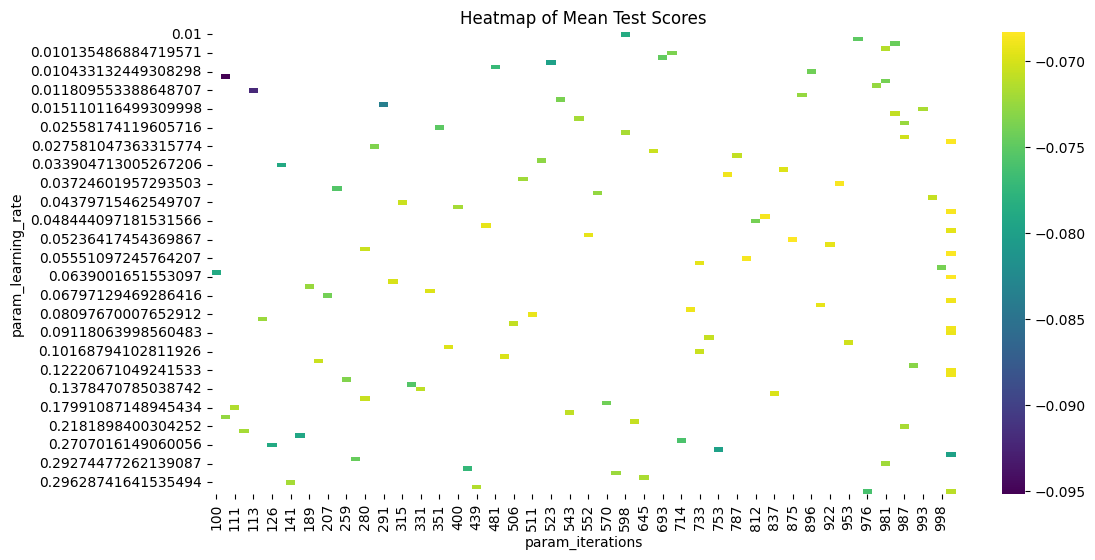

In [29]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [30]:
best_model = opt.best_estimator_

In [31]:
preds = best_model.predict(X_test)
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(by='Error', ascending=False).head(30)
print(top_30_errors)

      Ticker        Date  Future_Price_pct_diff_1  Predicted     Error
22705   SMCI  2024-06-30                 2.553191   0.557219  1.995972
26167    VST  2024-06-30                 0.814395   0.333050  0.481345
10674   FSLR  2024-09-30                 0.335664  -0.039172  0.374836
4599     CCL  2024-02-29                -0.048040   0.290456  0.338496
17617   MRNA  2024-09-30                 0.114396  -0.161910  0.276306
17970   MTCH  2024-03-31                -0.068283   0.172324  0.240607
19499     ON  2024-03-31                -0.101345   0.136900  0.238245
6350    CRWD  2024-04-30                 0.654692   0.423561  0.231131
18370    NEM  2024-06-30                -0.127259   0.103165  0.230424
1237    ALGN  2024-03-31                -0.102581   0.121687  0.224268
26168    VST  2024-09-30                 0.237669   0.031393  0.206275
19009   NVDA  2024-07-31                 0.404360   0.204487  0.199873
8075     DVA  2024-03-31                 0.108220   0.298592  0.190372
12384 

<Axes: >

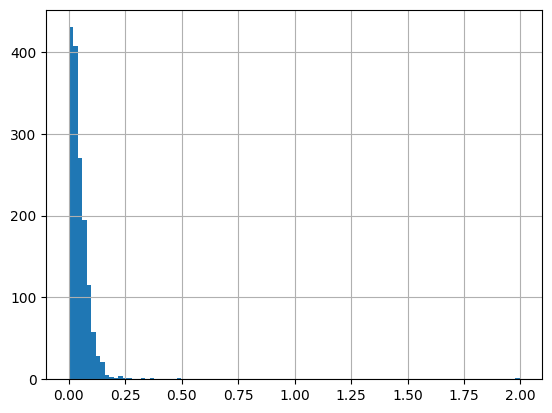

In [32]:
error_df['Error'].hist(bins=100)

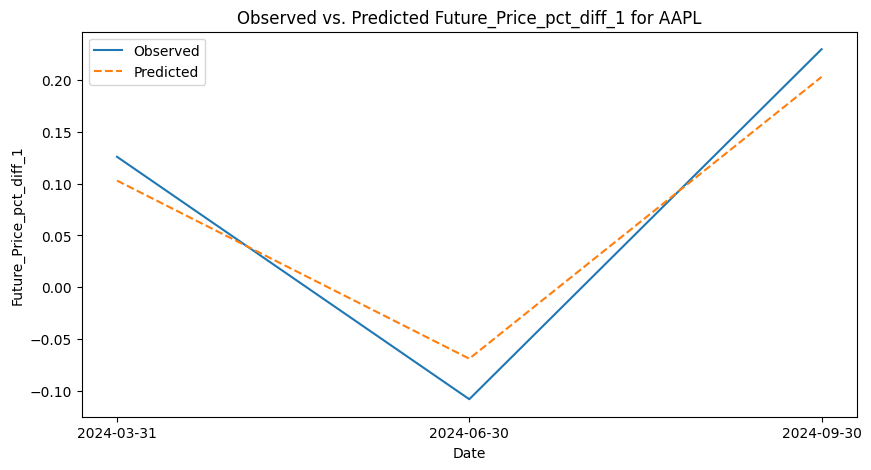

Mean error: 0.029630071376261807


In [37]:
ticker = 'AAPL'

ticker_example = test_df[test_df['Ticker'] == ticker]
plt.figure(figsize=(10, 5))
plt.plot(ticker_example['Date'], ticker_example[target], label='Observed')
plt.plot(ticker_example['Date'], best_model.predict(Pool(ticker_example[features], cat_features=cat_features)),
         label='Predicted', linestyle='--')
plt.title(f'Observed vs. Predicted {target} for {ticker}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

print(f'Mean error: {error_df.loc[error_df["Ticker"]==ticker, "Error"].mean()}')